## Check seperating optimizers for discriminating real and fake
## Experiment with https://github.com/soumith/ganhacks hints

In [1]:
import os,random, math
from PIL import Image
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge, AveragePooling2D
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten

from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.losses import categorical_crossentropy
from keras import backend as K

from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
import random, sys, keras
from keras.models import Model, Sequential
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
from tqdm import tqdm
from sklearn.utils import shuffle


Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1" #On rd010532 0 = Tesla, 1 = Quadro

In [3]:
def draw_model_on_interactive_session(model):

    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))


In [4]:
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255

print(np.min(X_train), np.max(X_train))

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


0 255
X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [5]:
# Build Generative model ...
def generator_model():
    model = Sequential()
    model.add(Dense(1024, input_shape=(100,), activation='tanh'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model

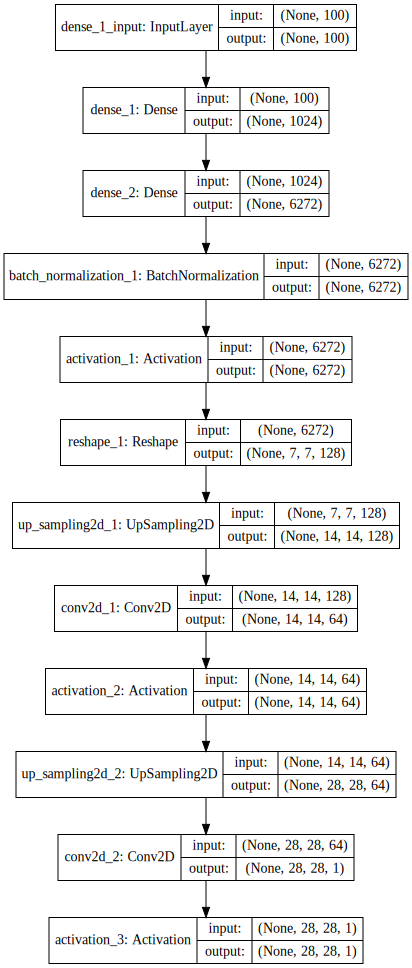

In [6]:
draw_model_on_interactive_session(generator_model())

In [7]:
# Build Discriminative model ...
def discriminator_model():
    model = Sequential()
    model.add(
            Conv2D(64, (5, 5),
            padding='same',
            input_shape=(28, 28, 1))
            )
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

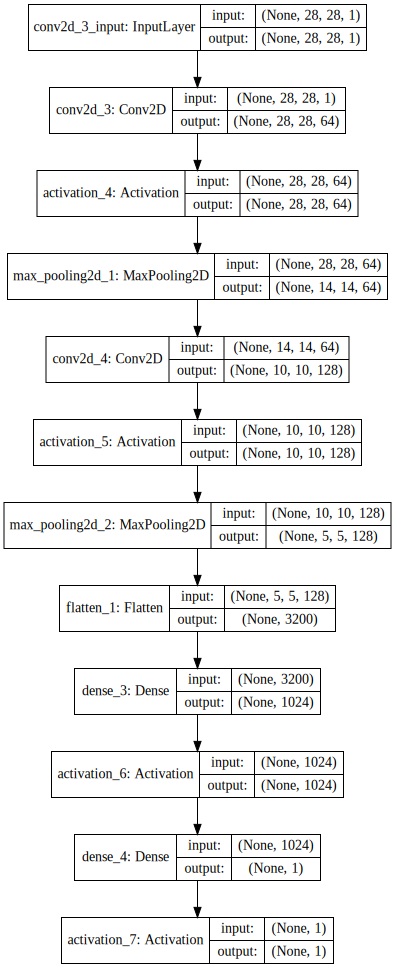

In [8]:
draw_model_on_interactive_session(discriminator_model())

In [9]:
# Build stacked GAN model
# need new loss function here? Maximise entropy between two classes while
#discriminator is trying to reduce it?
def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    
    return model

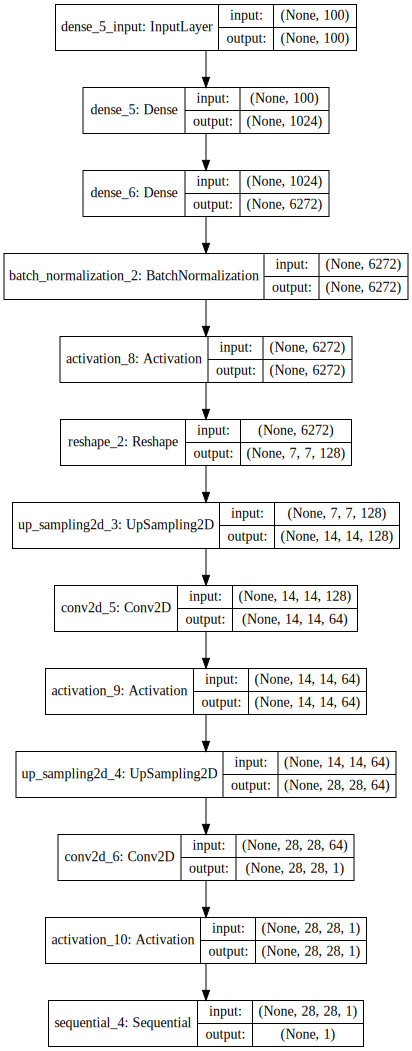

In [10]:
draw_model_on_interactive_session(generator_containing_discriminator(generator_model(), discriminator_model()))
                                  

In [11]:


def plot_loss(losses):   
    
    if ax.lines:
        ax.lines[0].set_data(list(range(len(losses["d_loss"]))), losses["d_loss"])
        ax.lines[1].set_data(list(range(len(losses["g"]))), losses["g"])
        ax.lines[2].set_data(list(range(len(losses["accuracy"]))), losses["accuracy"])
        ax.autoscale(True)
        
    else:        
        ax.plot(list(range(len(losses["d_loss"]))), losses["d_loss"], label='discriminator loss (real)')
        ax.plot(list(range(len(losses["g"]))), losses["g"], label='generator loss')
        ax.plot(list(range(len(losses["accuracy"]))), losses["accuracy"], label='accuracy')
        ax.autoscale()        
        
    ax.relim()
    ax.autoscale_view()
    ax.legend(['Discriminator Loss', 'Generator Loss', 'Discriminator Accuracy'])
    fig.canvas.draw()

    
def plot_generated_images(n_ex=16,dim=(4,4), figsize=(10,10), noise=None ):
    
    if noise is None:
        noise = np.random.normal(-1,1,size=[n_ex,100])
        
    generated_images = generator.predict(noise)
    generated_images = generated_images*127.5 + 127.5 #undo scaling
    
    for i in range(generated_images.shape[0]):
        #plt.subplot(dim[0],dim[1],i+1)
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    
    plt.show()
    image_fig.canvas.draw()


In [12]:
def pretrain_discriminator(n_samples=100, batch_size=10):
    make_trainable(discriminator,True)

    X_real, y_real = generate_discriminator_training_batch(True, n_samples)
    X_fake, y_fake = generate_discriminator_training_batch(False, n_samples)
    
    X = np.concatenate([X_real, X_fake])
    y = np.concatenate([y_real, y_fake])
    
    discriminator.fit(X, y, epochs=1, batch_size=batch_size, shuffle=True)

    return calculate_discriminator_accuracy(X, y)

In [13]:
def perform_discriminator_training_steps(start, batch_size=50):
    
    discriminator.trainable = True

    X_real, y_real = generate_discriminator_training_batch(True, start, batch_size)
    X_fake, y_fake = generate_discriminator_training_batch(False, start, batch_size)

    X = np.concatenate([X_real, X_fake])
    y = np.concatenate([y_real, y_fake])
    discriminator_history = discriminator.train_on_batch(X,y)
    losses['d_loss'].append(discriminator_history)
    
    

In [14]:
def generate_discriminator_training_batch(real, start, batch_size):
  
    # 1 is a real sample, 0 is generated. But use a range of values
    # around 1 or 0 to add some noise to help the training
  
    if real:
        X = X_train[range(start, start+batch_size),:,:,:]
        X = (X.astype(np.float32)-127.5)/127.5 #scale
        y=np.ones(batch_size)
    else:        
        noise_gen = np.random.normal(-1,1,size=[batch_size,100])
        X = generator.predict(noise_gen)            
        y=np.zeros(batch_size)
    
    return X, y

In [19]:
 # train Generator-Discriminator stack on input noise to non-generated output class
def perform_generator_discriminator_stack_training_steps(batch_size=50):
    #(1.1 - 0.9) *np.random.random_sample((batch_size,)) + 0.9
    
    discriminator.trainable=False

    noise_input = np.random.normal(-1,1,size=[batch_size, 100])
    y = np.ones(batch_size)
    gan_history = discriminator_generator_stack.train_on_batch(noise_input, y)
    losses['g'].append(gan_history)



In [20]:
losses = {'d_loss':[], 'g':[], 'accuracy':[]}

In [21]:
discriminator = discriminator_model()
generator = generator_model()
discriminator_generator_stack = generator_containing_discriminator(generator, discriminator)
 
discriminator_optimiser = SGD(lr=0.0005, momentum=0.9, nesterov=True)
generator_optimiser = SGD(lr=0.0015, momentum=0.9, nesterov=True)
generator.compile(loss='binary_crossentropy', optimizer="SGD")
discriminator_generator_stack.compile(loss='binary_crossentropy', optimizer=generator_optimiser)
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimiser)

batch_size=128

In [ ]:
X_real, y_real = generate_discriminator_training_batch(True, 10)
X_fake, y_fake = generate_discriminator_training_batch(False, 10)

X = np.concatenate([X_real, X_fake])
y = np.concatenate([y_real, y_fake])

discriminator.predict(X)


In [23]:
60000/128

468.75

<IPython.core.display.Javascript object>


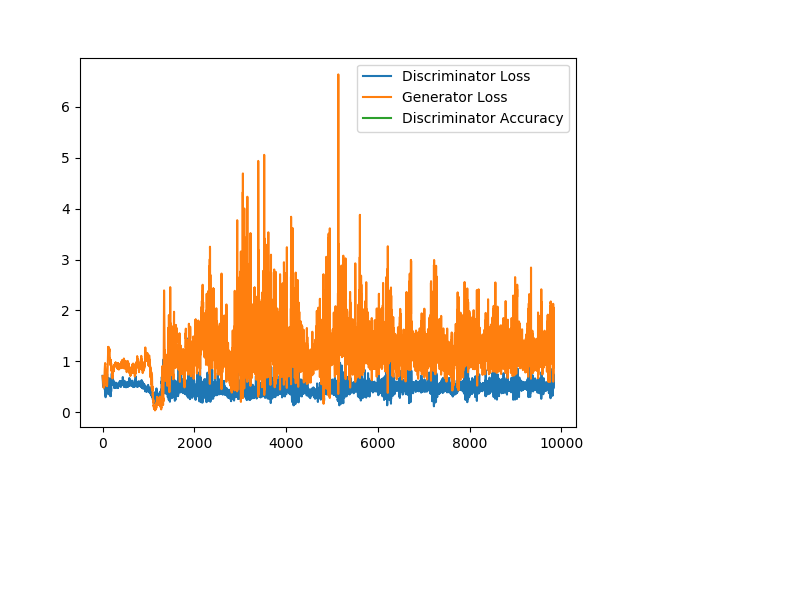

<IPython.core.display.Javascript object>


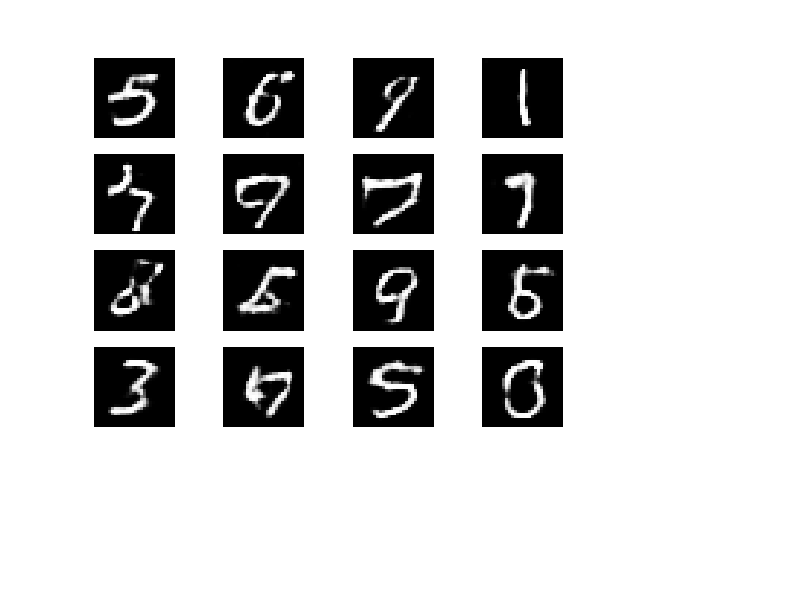

number of batches:  468
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21


In [ ]:
%matplotlib notebook

batch_size = 128

fig, ax = plt.subplots(1, 1)

image_fig, image_ax = plt.subplots(1, 1)

training_data_size=X_train.shape[0]
n_batches = int(training_data_size/batch_size)
print('number of batches: ', n_batches)
    
for i in range(100):
    print('epoch: ', i)
    
    training_data_index=0
        
    for train_batch in range(n_batches):
        perform_discriminator_training_steps(training_data_index, batch_size)
        perform_generator_discriminator_stack_training_steps(batch_size)

        training_data_index += batch_size
    
    if i % 1 == 0:
        fig
        plot_loss(losses)
        image_fig
        plot_generated_images()
    if i%10 == 0:
        generator.save('generator.h5')
        discriminator.save('discriminator.h5')

In [ ]:
def train(BATCH_SIZE=128):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    #X_train = X_train[:, :, :, None]
    #X_test = X_test[:, :, :, None]
    # X_train = X_train.reshape((X_train.shape, 1) + X_train.shape[1:])
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

    d = discriminator_model()
    g = generator_model()
    d_on_g = generator_containing_discriminator(g, d)
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)
    d.trainable = True
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    for epoch in range(100):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                Image.fromarray(image.astype(np.uint8)).save(
                    str(epoch)+"_"+str(index)+".png")
            X = np.concatenate((image_batch, generated_images))
            y = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)
            y = y.reshape((y.shape[0], 1))
            d_loss = d.train_on_batch(X, y)
            print("batch %d d_loss : %f" % (index, d_loss))
            noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, [1] * BATCH_SIZE)
            d.trainable = True
            print("batch %d g_loss : %f" % (index, g_loss))
            if index % 10 == 9:
                g.save_weights('generator', True)
                d.save_weights('discriminator', True)

In [ ]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

In [ ]:
train()